In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import GPy, pickle
import pandas as pd
import gc

In [3]:
import sys
sys.path.insert(0, '../source')

In [4]:
from incremental_run import Data, loadData, compute_several_stats, RunFullGP, RunPoE, RunSparseGP

In [5]:
from CPoE import CPoE

## create 2D data with global and local patterns

In [6]:
# likelihood
sig2_noise = 0.2 
likG = GPy.likelihoods.Gaussian(variance=sig2_noise)

In [7]:
# kernel with 2 RBF parts with small and big lengthscale
D = 2
kern1 = GPy.kern.RBF(input_dim = D, variance = .2, lengthscale = np.ones(D)*np.array([.125, 0.125]), ARD = True)
kern2 = GPy.kern.RBF(input_dim = D, variance = 1.1, lengthscale = np.ones(D)*np.array([.5, 0.5]), ARD = True)
kernG = kern1 + kern2    

In [8]:
# either generate data or load it
LOAD = True
seed = 999

In [9]:
if not LOAD:
    # generate training/testing data from a full GP (takes several minutes)
    DD = Data(kern=kernG, sig2_noise=sig2_noise, Ntrain=2**13, Ntest=2**10, seed=seed, UNIF=False, GRID=True, kernsAdd=[kern1,kern2]);
    
    # safe it 
    with open('datasets/dataSYN2', 'wb') as handle:
        pickle.dump(DD, handle)

In [10]:
if LOAD:
    with open('datasets/dataSYN2', 'rb') as handle:
        DD = pickle.load(handle)

In [11]:
# plot the data

In [12]:
def plot_2D_addKernel(self, figsize=(4,4), lev=20):#self=Data object!

    n_kern = len(self.kernsAdd)

    f, axs = plt.subplots(1,n_kern+1, sharex=True, sharey=True, figsize=((n_kern+1)*figsize[0],figsize[1]))

    titles = ['RBF local', 'RBF global','sum']
    for k in range(n_kern):
        fs = self.Zks[k][self.Ntrain:,0]


        axs[k].tricontour(self.X_test[:,0], self.X_test[:,1], fs, lev, cmap=self.cmap)
        axs[k].set_title(titles[k], size=15)


    axs[-1].tricontour(self.X_test[:,0], self.X_test[:,1], self.f_test, lev, cmap=self.cmap)
    axs[-1].set_title(titles[-1], size=15)
    
    axs[-1].set_xticks([])
    axs[-1].set_yticks([])

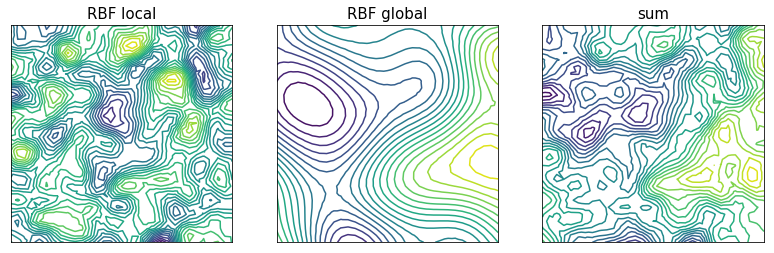

In [13]:
plot_2D_addKernel(DD, lev=20, figsize=(4.5,4) )
#plt.savefig('data2D'+'.pdf', bbox_inches = 'tight', pad_inches = 0)

## run full GP

In [14]:
rFullGP = RunFullGP(DD, kernG, likelihood=likG, seed=seed).run()

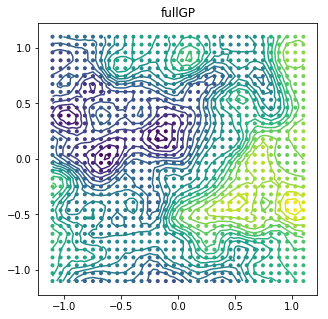

,time,lik,CRPS,errF,errAbs,negLogP,cov,CRPS_IN,errF_IN,errAbs_IN,negLogP_IN,cov_IN,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
fullGP,31.211,-5439.45,0.27,0.159,0.098,0.423,0.943,0.257,0.074,0.059,0.283,0.944,0.312,0.3,0.224,0.879,0.942


In [15]:
rFullGP.plot_full((5,5))
resGP = rFullGP.compute_stats()
resGP

# run independent PoEs

In [16]:
namsePoE = np.array(['minVar','NN','PoE-1/J', 'GPoE-scaled','BCM','RBCM'])

In [17]:
RESP = []
for Kj in np.arange(0,7):  # loop over different number of experts
    Kk = 2**Kj
    print(Kk)

    # run all PoE methods
    argsPartPoE = {'KDTREE':True, 'B_stop':np.ceil(DD.Ntrain/Kk)}
    rPoE = RunPoE(DD, Kk, kernG, likG,  seed=seed, **argsPartPoE)
    runsPoE = [rPoE.run(nam) for nam in namsePoE]

    # store results 
    RESP.append( compute_several_stats(runsPoE, rFullGP.m, rFullGP.v) )

    # garbage collecting
    gc.collect()

1
new K is 1
0.0005586147308349609
2
new K is 2
0.0023415088653564453
4
new K is 4
0.003473043441772461
8
new K is 8
0.004375457763671875
16
new K is 16
0.00570988655090332
32
new K is 32
0.007236003875732422
64
new K is 64
0.009286642074584961


In [18]:
# show results for 1 run
RESP[3]

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
minVar,5.567,-5517.504,4.257,0.048,0.272,0.171,0.106,0.443,0.941,2.267,...,0.065,0.293,0.944,10.760,0.083,0.318,0.322,0.240,0.932,0.933
NN,5.602,-5517.504,4.257,0.048,0.272,0.171,0.106,0.443,0.941,2.267,...,0.065,0.293,0.944,10.760,0.083,0.318,0.322,0.240,0.932,0.933
PoE-1/J,5.746,-5517.504,343.784,0.414,0.364,0.464,0.358,1.746,0.989,333.219,...,0.307,1.608,0.995,378.298,0.532,0.452,0.667,0.525,2.197,0.971
GPoE-scaled,5.787,-5517.504,52.863,0.122,0.280,0.206,0.146,0.808,0.967,58.310,...,0.114,0.709,0.973,35.068,0.124,0.323,0.342,0.252,1.131,0.946
BCM,5.861,-5517.504,280.202,0.233,0.306,0.272,0.214,0.421,0.831,323.198,...,0.196,0.295,0.816,139.750,0.225,0.326,0.339,0.272,0.833,0.879
RBCM,5.825,-5517.504,77.136,0.115,0.280,0.198,0.140,0.299,0.896,92.742,...,0.110,0.102,0.886,26.157,0.108,0.317,0.323,0.241,0.939,0.925


In [ ]:
 pd.DataFrame( [res['KLx1000'] for res in RESP] )

,minVar,NN,PoE-1/J,GPoE-scaled,BCM,RBCM
KLx1000,0.000,-0.000,0.000,0.000,0.000,2.661
KLx1000,1.084,1.084,74.488,9.379,28.172,13.994
KLx1000,2.401,2.401,199.119,24.166,162.334,44.031
KLx1000,4.257,4.257,343.784,52.863,280.202,77.136
KLx1000,6.157,6.157,482.663,90.925,595.865,152.276
KLx1000,10.724,12.386,576.733,136.033,1379.320,310.962
KLx1000,16.767,19.148,671.489,191.737,2432.990,506.429


# run sparse GPs with different number of inducing points

In [ ]:
M = 50
MMs = np.array([M, 2*M, 3*M, 4*M, 4*M, 6*M,  8*M, 10*M, 15*M, 20*M])

runsSparse = [ RunSparseGP(DD, kernG, m, likelihood=likG, seed=seed).run(OPT_TH=False) for m in MMs]

nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize


In [ ]:
resSP = compute_several_stats(runsSparse, rFullGP.m, rFullGP.v)
resSP

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
sparse50,6.720,-10052.255,199.611,0.323,0.326,0.364,0.280,1.190,0.964,172.436,...,0.221,0.997,0.964,288.383,0.458,0.403,0.550,0.470,1.821,0.962
sparse100,7.406,-7586.495,107.109,0.227,0.302,0.281,0.203,0.868,0.959,80.500,...,0.147,0.656,0.959,194.031,0.349,0.379,0.470,0.384,1.561,0.958
sparse150,8.325,-6537.297,60.154,0.169,0.288,0.244,0.165,0.702,0.945,37.123,...,0.105,0.482,0.948,135.389,0.283,0.366,0.442,0.361,1.420,0.938
sparse200,9.480,-6092.808,36.017,0.129,0.281,0.213,0.138,0.603,0.947,21.087,...,0.086,0.406,0.946,84.788,0.217,0.342,0.389,0.305,1.250,0.950
sparse200,9.491,-6092.808,36.017,0.129,0.281,0.213,0.138,0.603,0.947,21.087,...,0.086,0.406,0.946,84.788,0.217,0.342,0.389,0.305,1.250,0.950
sparse300,11.017,-5567.249,6.522,0.049,0.270,0.160,0.100,0.468,0.944,1.597,...,0.062,0.308,0.943,22.607,0.097,0.311,0.300,0.223,0.991,0.950
sparse400,13.552,-5473.674,2.539,0.032,0.269,0.154,0.096,0.440,0.945,0.228,...,0.060,0.290,0.945,10.087,0.065,0.308,0.288,0.214,0.933,0.946
sparse500,14.870,-5453.458,1.330,0.023,0.270,0.157,0.097,0.435,0.946,0.065,...,0.059,0.286,0.945,5.463,0.046,0.311,0.295,0.220,0.921,0.950
sparse750,21.770,-5440.562,0.162,0.009,0.270,0.156,0.097,0.423,0.943,0.002,...,0.059,0.283,0.944,0.686,0.019,0.310,0.294,0.219,0.879,0.942
sparse1000,29.393,-5439.728,0.054,0.005,0.270,0.157,0.097,0.423,0.942,0.000,...,0.059,0.283,0.944,0.229,0.010,0.311,0.297,0.221,0.878,0.938


In [ ]:
gc.collect()

0

# run CPoE

In [ ]:
RESS_CPoE = []
for Cj in range(12): # loop over different degree of correlation
    print(Cj)

    # run CPoE
    res, _ = CPoE(DD.X_train, DD.y_train, kernG, likG, 2**5, Cj+1, 0.5, y_test=DD.y_test, X_test=DD.X_test, f_test=DD.f_test, seed=seed)

    RESS_CPoE.append(res)

    gc.collect()

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
RES_CPoE = compute_several_stats( RESS_CPoE, mFull=rFullGP.m, vFull=rFullGP.v)
RES_CPoE

# plot results

In [ ]:
f, axs = plt.subplots(1,4, sharex=True, sharey=False, figsize=(6.5*4,5) )


xlim = int(resGP['time'][0]) + 5
msFull = 15

cols = ['r','c','m']
algnames = ['minVar', 'GPoE', 'BCM']
algnames2 = ['minVar', 'GPoE-scaled', 'BCM']

size_title = 18
size_xlab = 18
size_ylab = 18
leg_size = 20


crit_names = ['KLx1000', 'errFull', 'cov', 'lik']
for i in range(len(axs)):
    ax = axs[i]



    ax.plot(RES_CPoE['time'], RES_CPoE[crit_names[i]], 'g.-', markersize=10, label='CPoE')
    ax.plot(resSP['time'], resSP[crit_names[i]], 'b.-', markersize=10, label='sparse GP')

    ts_PoE = pd.DataFrame( [res['time'] for res in RESP] )
    cr_PoE =pd.DataFrame( [res[crit_names[i]] for res in RESP] )
    for j,alg_n in enumerate(algnames2):
        ax.plot( ts_PoE[alg_n], cr_PoE[alg_n], cols[j]+'.-', markersize=10, label=algnames[j])

    ax.plot(resGP['time'], 0, 'ks', label='full GP', markersize=msFull)
    ax.plot(np.arange(xlim), np.ones(xlim)*0, 'k:')

    
    
    if i==0:
        ax.set_ylabel('KL', size=size_ylab)
        ax.set_xlabel('time [s]', fontsize=size_xlab)
        ax.set_yscale('symlog', linthreshy=2)

        ax.set_ylim(-0.5)
        ax.set_xlim(-2,xlim)
        ax.set_title('KL to full GP', size=size_title)
        ax.plot(np.arange(xlim), np.ones(xlim)*0, 'k:')

        ax.legend(loc=8, fontsize=leg_size, bbox_to_anchor=(2.3,-0.4), ncol=6);
    elif i==1:
        ax.set_yscale('symlog', linthreshy=0.15)

        ax.set_ylim(-0.03)
        ax.set_title('RMSE to full GP', size=size_title)
        ax.set_ylabel('RMSE', size=size_ylab)
        ax.set_xlabel('time [s]', fontsize=size_xlab)
        ax.plot(np.arange(xlim), np.ones(xlim)*0, 'k:')
    elif i==2:
        ax.set_ylim(0.915,.99)
        ax.set_title('95%-coverage', size=size_title)
        ax.set_ylabel('COV', size=size_ylab)
        ax.set_xlabel('time [s]', fontsize=size_xlab)
        ax.plot(np.arange(xlim), np.ones(xlim)*.95, 'b:')
        ax.plot(np.arange(xlim), np.ones(xlim)*resGP['cov'][0], 'k:')
    elif i==3:
        ax.set_ylim(-5750, -5400)
        ax.set_title('log marginal likelihood', size=size_title)
        ax.set_ylabel('LML', size=size_ylab)
        ax.set_xlabel('time [s]', fontsize=size_xlab)
        ax.plot(np.arange(xlim), np.ones(xlim)*resGP['lik'][0], 'k:')



#plt.savefig('synthetic2D'+'.pdf', bbox_inches = 'tight', pad_inches = 0)